In [10]:
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random
from matplotlib.lines import Line2D
import pandas as pd
from time import time
import numpy as np
from tqdm import tqdm
import os
import netCDF4 as nc
from progressbar import progressbar
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
import xarray as xr
import random
from scipy.interpolate import LinearNDInterpolator
from itertools import product
from scipy.signal import savgol_filter
tqdm.pandas()

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random

%matplotlib inline

flooded_area = {'north': 28.1, 'south': 26.6, 'west': 58.9, 'east': 60.7}
iran = {'north': 31, 'south': 26, 'west': 59, 'east': 64}


In [19]:
def grid_box(df, target_value='sr', use_median=True):
    df['lat'] = df['lat'].apply(lambda x: round_nearest(x, 0.1))
    df['long'] = df['long'].apply(lambda x: round_nearest(x, 0.1))
    
    if use_median:
        df = df.groupby(['long', 'lat'], as_index=False)[target_value].median()
    else:
        df = df.groupby(['long', 'lat'], as_index=False)[target_value].mean()
    
    return df


def filter_cygnss_df(df: pd.DataFrame, area: dict) -> pd.DataFrame:
    if 'sp_lat' in df.columns:
        new_df = df[df['sp_lat'] <= area['north']]
        new_df = new_df[new_df['sp_lat'] >= area['south']]
        new_df = new_df[new_df['sp_lon'] >= area['west']]
        new_df = new_df[new_df['sp_lon'] <= area['east']]
    else:
        new_df = df[df['lat'] <= area['north']]
        new_df = new_df[new_df['lat'] >= area['south']]
        new_df = new_df[new_df['long'] >= area['west']]
        new_df = new_df[new_df['long'] <= area['east']]

    return new_df

def round_nearest(x, a):
    return round(x / a) * a

In [29]:
cyg_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/31-59-26-64/CYGNSS 2019 to 2021'
smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Iran 2019-2021.csv'
# raw_smap_df = pd.read_csv(smap_path)[['lat', 'long', 'time', 'smap_sm']]

raw_cygnss_df = pd.read_csv(cyg_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})

# raw_cygnss_df = raw_cygnss_df[(raw_cygnss_df['day_of_year'] > 400) & (raw_cygnss_df['day_of_year'] < 401)]
# print(raw_cygnss_df.head())


In [48]:
# Read Data Before Rain
raw_cygnss_df_before = raw_cygnss_df[(raw_cygnss_df['day_of_year'] >= 365 + 366 + 117) & (raw_cygnss_df['day_of_year'] <= 365 + 366 + 119)]
# raw_cygnss_df_before = raw_cygnss_df[(raw_cygnss_df['day_of_year'] == 365 + 366 + 118)]
raw_cygnss_df_before = filter_cygnss_df(raw_cygnss_df_before, flooded_area)
raw_cygnss_df_before = grid_box(raw_cygnss_df_before, 'sr', False)

# Read Data During Rain
raw_cygnss_df_during = raw_cygnss_df[(raw_cygnss_df['day_of_year'] >= 365 + 366 + 124) & (raw_cygnss_df['day_of_year'] <= 365 + 366 + 126)]
# raw_cygnss_df_after = raw_cygnss_df[(raw_cygnss_df['day_of_year'] == 365 + 366 + 128)]

raw_cygnss_df_during = filter_cygnss_df(raw_cygnss_df_during, flooded_area)
raw_cygnss_df_during = grid_box(raw_cygnss_df_during, 'sr', False)

# Read Data After Rain
raw_cygnss_df_after = raw_cygnss_df[(raw_cygnss_df['day_of_year'] >= 365 + 366 + 127) & (raw_cygnss_df['day_of_year'] <= 365 + 366 + 129)]
# raw_cygnss_df_after = raw_cygnss_df[(raw_cygnss_df['day_of_year'] == 365 + 366 + 128)]

raw_cygnss_df_after = filter_cygnss_df(raw_cygnss_df_after, flooded_area)
raw_cygnss_df_after = grid_box(raw_cygnss_df_after, 'sr', False)


vmin = min(raw_cygnss_df_before['sr'].min(), raw_cygnss_df_during['sr'].min(), raw_cygnss_df_after['sr'].min())
vmax = max(raw_cygnss_df_before['sr'].max(), raw_cygnss_df_during['sr'].max(), raw_cygnss_df_after['sr'].max())



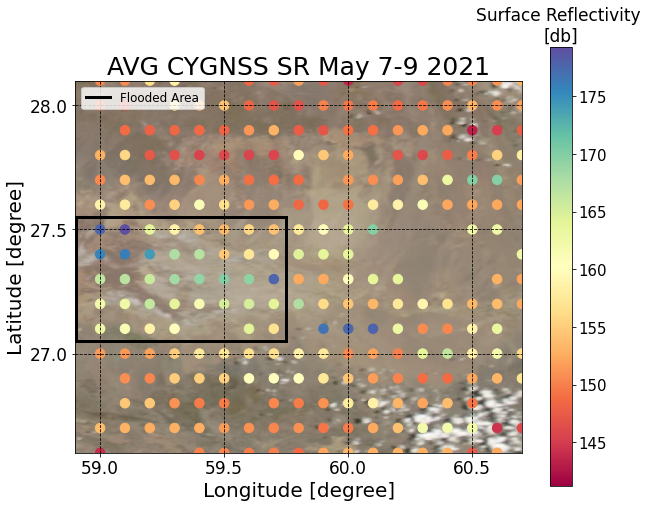

In [102]:
# After Rain

after_rain_path_img = '/Users/vegardhaneberg/Desktop/Time Series/Iran/Flood/snapshot-2021-05-08.jpg'

plt.rcParams["figure.autolayout"] = True
im = plt.imread(after_rain_path_img)
fig, ax = plt.subplots(figsize=(9, 9))

im = ax.imshow(im, extent=[flooded_area['west'], flooded_area['east'], flooded_area['south'], flooded_area['north']])

plt.title('AVG CYGNSS SR May 7-9 2021', fontsize=25)
plt.xlabel('Longitude [degree]', fontsize=20)
plt.ylabel('Latitude [degree]', fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.grid(color='black', linestyle='--')

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Flood Area
# ax.add_patch(Rectangle((59, 27.05), 1.1, 0.65, lw=3, fill=False, edgecolor='blue'))

# Legend
# legend_elements = [Line2D([0], [0], color='blue', lw=3, label='Flooded Area Jan 2020')]
# ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Grid
# ax.grid(color='black', ls='-.')

plt.scatter(raw_cygnss_df_after['long'], 
            raw_cygnss_df_after['lat'], 
            c=list(raw_cygnss_df_after['sr']), 
            s=90, 
            cmap='Spectral',
            vmin=vmin,
            vmax=vmax)

bar = plt.colorbar(shrink=0.7)
bar.ax.set_title('Surface Reflectivity \n[db]', fontsize=17)
bar.ax.tick_params(labelsize=15)


# Flood Area
ax.add_patch(Rectangle((58.901, 27.05), 0.85, 0.5, lw=3, fill=False, edgecolor='black'))

# Legend
legend_elements = [Line2D([0], [0], color='black', lw=3, label='Flooded Area')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

plt.tight_layout()


plt.savefig('/Users/vegardhaneberg/Desktop/Time Series/Iran/Flood/After Flood.png')

plt.show()

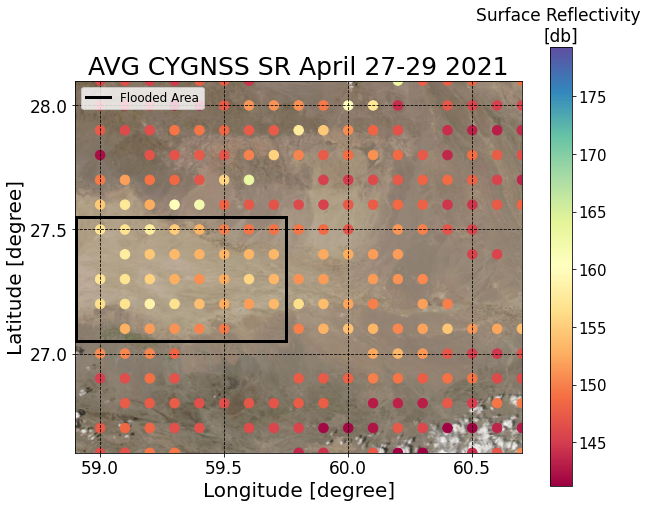

In [103]:
before_rain_path_img = '/Users/vegardhaneberg/Desktop/Time Series/Iran/Flood/snapshot-2021-04-28.jpg'

plt.rcParams["figure.autolayout"] = True
im = plt.imread(before_rain_path_img)
fig, ax = plt.subplots(figsize=(9, 9))

im = ax.imshow(im, extent=[flooded_area['west'], flooded_area['east'], flooded_area['south'], flooded_area['north']])

plt.title('AVG CYGNSS SR April 27-29 2021', fontsize=25)
plt.xlabel('Longitude [degree]', fontsize=20)
plt.ylabel('Latitude [degree]', fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Flood Area
# ax.add_patch(Rectangle((59, 27.05), 1.1, 0.65, lw=3, fill=False, edgecolor='blue'))

# Legend
# legend_elements = [Line2D([0], [0], color='blue', lw=3, label='Flooded Area Jan 2020')]
# ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Grid
# ax.grid(color='black', ls='-.')

# Save Figure



plt.scatter(raw_cygnss_df_before['long'], 
            raw_cygnss_df_before['lat'], 
            c=list(raw_cygnss_df_before['sr']), 
            s=90, 
            cmap='Spectral',
            vmin=vmin,
            vmax=vmax)

# Flood Area
ax.add_patch(Rectangle((58.901, 27.05), 0.85, 0.5, lw=3, fill=False, edgecolor='black'))

# Legend
legend_elements = [Line2D([0], [0], color='black', lw=3, label='Flooded Area')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

bar = plt.colorbar(shrink=0.7)
bar.ax.set_title('Surface Reflectivity \n[db]', fontsize=17)
bar.ax.tick_params(labelsize=15)

ax.grid(color='black', linestyle='--')

plt.savefig('/Users/vegardhaneberg/Desktop/Time Series/Iran/Flood/Before Flood.png')

plt.show()

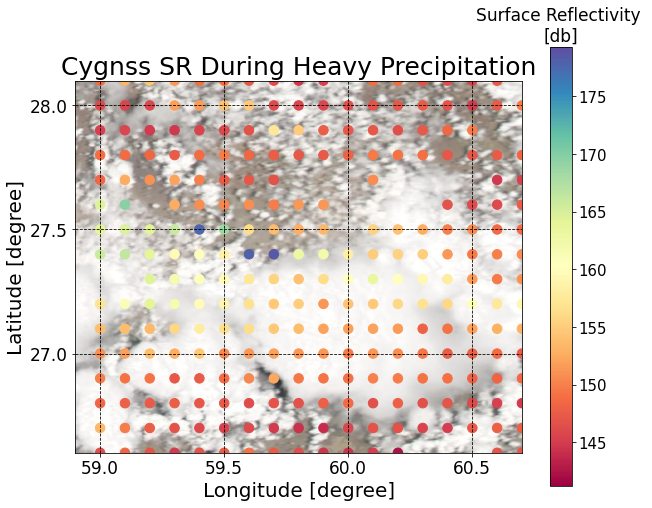

In [104]:
during_rain_path_img = '/Users/vegardhaneberg/Desktop/Time Series/Iran/Flood/snapshot-2021-05-01.jpg'

plt.rcParams["figure.autolayout"] = True
im = plt.imread(during_rain_path_img)
fig, ax = plt.subplots(figsize=(9, 9))

im = ax.imshow(im, extent=[flooded_area['west'], flooded_area['east'], flooded_area['south'], flooded_area['north']])

plt.title('Cygnss SR During Heavy Precipitation', fontsize=25)
plt.xlabel('Longitude [degree]', fontsize=20)
plt.ylabel('Latitude [degree]', fontsize=20)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))


# Flood Area
# ax.add_patch(Rectangle((59, 27.05), 1.1, 0.65, lw=3, fill=False, edgecolor='blue'))

# Legend
# legend_elements = [Line2D([0], [0], color='blue', lw=3, label='Flooded Area Jan 2020')]
# ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Grid
# ax.grid(color='black', ls='-.')

# Save Figure



plt.scatter(raw_cygnss_df_during['long'], 
            raw_cygnss_df_during['lat'], 
            c=list(raw_cygnss_df_during['sr']), 
            s=90, 
            cmap='Spectral',
            vmin=vmin,
            vmax=vmax)

bar = plt.colorbar(shrink=0.7)
bar.ax.set_title('Surface Reflectivity \n[db]', fontsize=17)
bar.ax.tick_params(labelsize=15)

ax.grid(color='black', linestyle='--')

plt.savefig('/Users/vegardhaneberg/Desktop/Time Series/Iran/Flood/During Flood.png')

plt.show()

